# Notebook 2 - Inference

In this notebook we use `harissa` to perform network inference from a small dataset with 4 genes.

In [1]:
import numpy as np
import sys; sys.path += ['../']
from harissa import NetworkModel
from pathlib import Path
fname = 'data.txt'
data_path = Path(fname)

## Network

Let us start by defining a test network which will represent the ground truth. Note that the underlying dynamical model has quantitative parameters.

In [2]:
# Initialize the model
model = NetworkModel(4)
# Set degradation rates
model.d[0] = 1
model.d[1] = 0.2
# Set basal activities
model.basal[1:] = -5
# Set interactions
model.inter[0,1] = 10
model.inter[1,2] = 10
model.inter[1,3] = 10
model.inter[3,4] = 10
model.inter[4,1] = -10
model.inter[2,2] = 10
model.inter[3,3] = 10

The `harissa.utils` module provides `build_pos` and `plot_network` to visualize networks.

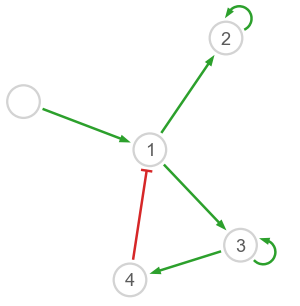

In [3]:
import matplotlib.pyplot as plt
from harissa.utils import build_pos, plot_network
# Number of genes including stimulus
G = model.basal.size
# Node labels and positions
names = [''] + [f'{i+1}' for i in range(G)]
pos = build_pos(model.inter) * 0.8
# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(model.inter, pos, axes=fig.gca(), names=names, scale=3)

## Dataset

We start by generating a sample time-course scRNA-seq dataset: here the main function is `model.simulate()`. The dynamical model is first run during a certain time without stimulus (`burnin` parameter) before activating it at $t=0$. Each single cell is then collected at a particular time point $t > 0$ during the simulated experiment: in this example there are 10 experimental time points and `C`/10 cells per time point.

In [4]:
# Simulate a time-course scRNA-seq dataset
if not data_path.is_file():
    # Number of cells
    C = 1000
    # Set the time points
    k = np.linspace(0, C, 11, dtype='int')
    t = np.linspace(0, 20, 10, dtype='int')
    print('Time points: ' + ', '.join([f'{ti}' for ti in t]))
    print(f'{int(C/t.size)} cells per time point (total {C} cells)')
    # Time point of each cell
    time = np.zeros(C, dtype='int')
    for i in range(10):
        time[k[i]:k[i+1]] = t[i]
    # Prepare data
    data = np.zeros((C,G), dtype='int')
    data[:,0] = time # Time points
    # Generate data
    for k in range(C):
        sim = model.simulate(time[k], burnin=5)
        data[k,1:] = np.random.poisson(sim.m[0])
    # Save data in basic format
    np.savetxt(fname, data, fmt='%d', delimiter='\t')
    print(f'Dataset file {fname} has been generated.')
else:
    data = np.loadtxt(fname, dtype=int, delimiter='\t')
    print(f'Dataset file {fname} loaded.')

Time points: 0, 2, 4, 6, 8, 11, 13, 15, 17, 20
100 cells per time point (total 1000 cells)
Dataset file data.txt has been generated.


Note that each scRNA-seq count is obtained by sampling from a Poisson distribution whose rate (mean) parameter is given by the corresponding continuous-valued mRNA level from the stochastic dynamical model. A typical way to implement technical factors (efficiency of reverse transcription, sequencing depth, etc.) would be to first multiply, before applying the Poisson distribution, the continuous values by scaling factors.

In [5]:
print(data)

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   6   0   0]
 ...
 [ 20  23  15 104 104]
 [ 20   2  54   9 148]
 [ 20   8  98 191 112]]


Each row corresponds to a single cell; the first column contains time points, while other columns contain gene expression counts.

## Network Inference

Here the main function is `model.fit()`. The first call may take a while due to the Numba compilation (activated by default).

In [6]:
model1 = NetworkModel()
# Calibrate the model
model1.fit(data)
# Show inferred links
print(model1.inter)

[[ 0.          4.31440281  0.15239797  0.16995842  0.09030469]
 [ 0.          4.68805338  2.19748205  2.06486797  0.01485657]
 [ 0.         -0.03942769  5.20934837  0.80001792  0.23226331]
 [ 0.         -0.04888055  0.46641089  5.4594253   1.90653132]
 [ 0.         -2.36083684  0.68133831  0.07567661  4.85294627]]



Note that the first column of `model.inter` will always be 0 since the stimulus (gene 0) has no feedback by hypothesis. In order to better visualize the results, we can apply a cutoff to edge weights:

In [7]:
cutoff = 1
inter_c = (np.abs(model1.inter) > cutoff) * model1.inter
print(inter_c)

[[ 0.          4.31440281  0.          0.          0.        ]
 [ 0.          4.68805338  2.19748205  2.06486797  0.        ]
 [ 0.         -0.          5.20934837  0.          0.        ]
 [ 0.         -0.          0.          5.4594253   1.90653132]
 [ 0.         -2.36083684  0.          0.          4.85294627]]


Hopefully this looks nice!

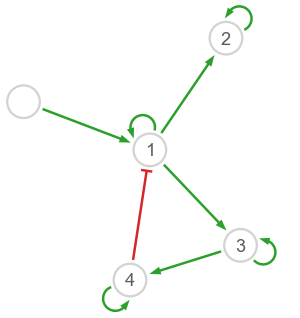

In [8]:
# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(inter_c, pos, axes=fig.gca(), names=names, scale=3)

Note that self-interactions are notoriously difficult to infer; they are usually not considered in performance evaluations.

### Option: disable Numba

To perform inference without Numba acceleration, set the `use_numba` option to `False` (useful when Numba is not available or generates errors).

In [9]:
model2 = NetworkModel()
# Calibrate the model
model2.fit(data, use_numba=False)
# Show inferred links
print(model2.inter)

[[ 0.          4.31440281  0.15239797  0.16995842  0.09030469]
 [ 0.          4.68805338  2.19748205  2.06486797  0.01485657]
 [ 0.         -0.03942769  5.20934837  0.80001792  0.23226331]
 [ 0.         -0.04888055  0.46641089  5.4594253   1.90653132]
 [ 0.         -2.36083684  0.68133831  0.07567661  4.85294627]]


You can now delete `data.txt` and try to generate new data with different values for `C` (number of cells) to see its impact on performance.